<a href="https://colab.research.google.com/github/the-black-viper/ml/blob/main/Javier_EE298_Exer2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Goal

Create a simple 3-layer neural network using purely python and numpy to predict the probabilities of normaly distributed values within $(-2\sigma, + 2\sigma)$ using the following architecture:

- 1 unit - Input Layer
- 64 units - Hidden Layer 1 + Relu Activation function
- 64 units - Hidden Layer 2 + Relu Activation function
- 1 unit - Output Layer

Hyperparameters
- Epochs: 20
- Batch size: 1
- Learning Rate = 0.1



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import floor

# Define Helper functions

In [36]:
def get_input():
  '''Get user input for the mean and std deviation
  Returns:
  user_mean(float) - mean
  user_std(float) - standard deviation
  '''
  mean_ = input('Enter mean: ')
  std_ = input('Enter standard deviation: ')
  user_mean = float(mean_)
  user_std = float(std_)
  return user_mean, user_std

In [3]:
def flatten_stack(arr):
  '''
  Flattens a 2D array and reshapes it into a single column vector
  
  Parameters:
  arr(numpy.array) - array to flatten

  Returns:
  reshaped_arr(numpy.array) - Single column vector of the input array
  '''
  flattened_arr = arr.flatten()
  # arr_new = np.array([[x] for x in flattened_arr])
  reshaped_arr = flattened_arr.reshape((flattened_arr.shape[0],1))
  return reshaped_arr

In [4]:
def scale(X):
  '''
  Normalizes X values for easier processing
  
  Parameters:
  X(numpy.array) - Raw input data to be normalized

  Returns:
  scaled_x(numpy.array) - Normalized input values
  mean_x(float) - mean of raw input data
  std_x(float) - standard deviation of raw input data
  '''
  mean_x = np.mean(X, axis=0)
  new = X - mean_x
  std_x = np.std(X, axis=0)
  scaled_x = new / std_x 
  return scaled_x, mean_x, std_x

In [5]:
def filter(input, output, n=10):
  '''
  Randomly selects n samples from the first row with a matching
  key from the second column.

  Parameters:
  input(numpy.array) - Input matrix to select samples
  output(int/float) - Value to match in the second column
  n(int, default = 10) - Number of samples to select

  Returns:
  new_x(numpy.array) - Row vector with size (n,)
  '''
  # Select all rows with the second column matching the output
  rows_with_output = input[(input[:, 1] == output)]
  # Get only the first column (X values)
  input_vals = rows_with_output[:,0]
  # Randomly pick 10 samples
  generator = np.random.default_rng(42)
  new_x = generator.choice(input_vals, n)
  return new_x

In [6]:
def random_range(lb, ub, n):
  '''Function to generate 'n' uniform random numbers in the interval (lb, ub]
  Parameters:
  lb - lower bound
  ub - upper bound
  n - number of random numbers to generate

  Returns:
  random_nums(numpy.array) - array of random numbers
  '''
  generator = np.random.default_rng(42)
  random_nums = generator.uniform(lb, ub, n)
  return random_nums

# Activation Functions

Define activation functions ReLu & Sigmoid and their respective derivatives.

In [8]:
'''
Parameters:
z - Weighted input matrix

Returns:
a (float) - 'Activated' values
'''

def relu(z):
  a = z * (z > 0)
  return a

def relu_prime(z):
  z[z < 0] = 0
  z[z > 0] = 1
  return z

def sigmoid(z):
  a = 1.0 / (1 + np.exp(-z))
  return a

def sigmoid_prime(z):
  a = sigmoid(z) * (1.0-sigmoid(z))
  return a 

# Cost Function
Define the MSE cost function 

In [9]:
def mse(yHat, y):
  ''' Returns the mean-squared-error of the predicted
  and target values
  Parameters:
  yHat(np.array) - predicted values
  y(np.array) - ground truth

  Returns:
  c - mean-squared-error
  '''
  c = np.sum((yHat - y)**2) / y.size
  return c

# Creating the Dataset
Target dataset is composed of random variables $(x)$ and their respective probability as the output $(y)$

A histogram plot is first generated to 'discretize' a normal random distribution. Eventually, inputs $(x)$ will be derived from the bin centers and the probabilities $(y)$ are calculated from the respective frequencies.

Enter mean: 100
Enter standard deviation: 10


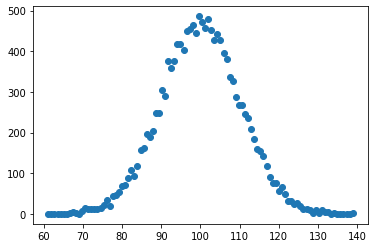

In [37]:
np.random.seed(42)
# Define mean and std
mu, sigma = get_input()
num_bins = 100
raw_sample_size = 15000
raws = np.random.normal(mu, sigma, raw_sample_size).round(4)
hist, bin_edges = np.histogram(raws, bins=num_bins)
# Half bin width
bin_half_val = np.diff(bin_edges)/2
# Get the bin centers
bin_centers = bin_edges[:-1] + np.diff(bin_edges)/2
# Plot the 'discretized' distribution
plt.scatter(bin_centers, hist)

## Select values in the range $(-2\sigma, +2\sigma)$

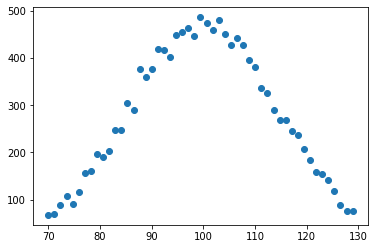

In [11]:
# Define bounds
lb = mu - 2*sigma
ub = mu + 2*sigma
# Select bin_centers inside the range [lb, ub]
bins = bin_centers[(bin_centers >= lb) & (bin_centers < ub)]
bin_idx = [np.where(bin_centers == bin) for bin in bins]

# Flatten index
bin_idx = np.array(bin_idx).flatten()
# Get frequency values for respective bin centers
hist_in_range = hist[bin_idx]

# Plot
plt.scatter(bins, hist_in_range)

## Generate dataset from the 'discretized' distribution.

To generate the dataset, random numbers are generated for each bin interval. The respective probabilities are calculated and the two sets of data are combined into a single matrix.

In [12]:
# Define number of samples for each bin
num_data = 1

# For each bin generate 10 random numbers in the interval.
x_raw = np.array([random_range(x-bin_half_val[0], x+bin_half_val[0], num_data).reshape((num_data, 1)) for x in bins])
x_raw = x_raw.reshape(len(bins),1,num_data)

# Generate the probabilities.
y_raw = np.array([np.full((num_data,1), round(f/raw_sample_size, 4)) for f in hist_in_range])

# Flatten the arrays
y_f = flatten_stack(y_raw)
x_f = flatten_stack(x_raw)

# Apply scaling and transformation
x_scaled,x_mean, x_std = scale(x_f)
scale1 = (x_f[0][0] -np.mean(x_f))/np.std(x_f)

# Finally, combine the inputs and outputs into a single 2D Matrix.
data_raw = np.hstack((x_scaled, y_f))

## Split Dataset
The dataset is shuffled to introduce randomness prior splitting.

In [13]:
def train_test_split(dataset, train_ratio, N, data_per_sample):
  '''
  Splits a 2D dataset into training and test sets
  Parameters:
  dataset(numpy.array) - 2D numpy array to split
  train_ratio(np.float) - float value of the training percentage
  N(int) - total number of samples
  data_per_sample - number of data sets 
  '''
  # Apply shuffling a second time
  np.random.shuffle(dataset)

  # Define training data ratio
  train_index = int(train_ratio*N)

  # Round train_index
  train_index = data_per_sample * floor(train_index/data_per_sample)
  # Get training and test sets
  training_set, test_set = dataset[0:train_index], dataset[train_index:]
  return training_set, test_set

In [15]:
# Split dataset to training and test sets
train_set, test_set = train_test_split(data_raw, 0.9, data_raw.shape[0], num_data)
np.random.shuffle(train_set)
np.random.shuffle(test_set)
# Training Set
x_training = train_set[:,0].reshape(-1,1)
y_training = train_set[:,1].reshape(-1,1)
# Test Set
x_testing = test_set[:,0].reshape(-1,1)
y_testing = test_set[:,1].reshape(-1,1)

# Network Discussion and Calculations

## Notations

- $W$: Weights
- $b$: Weights
- $z$: Weighted inputs + bias where: $z = Wx + b$
- $a$: Activated neurons where the activation function ($\sigma$) is applied to z,  where: $a = \sigma(z)$



## Forward Propagation

For each unit in each layer the vector of activated neurons ($a$) must be calculated. In order to calculate $a$, $z$ must first be calculated for each neuron in that particular layer.

From the notation previously defined. $z$ is simply defined as:

$$Weights * Input + bias$$

And looking at the network, for each layer the final output will be $a$. In the case of the first input layer, the input data will serve as the output $a$. Using this logic, then a generalized formula for $z$ is:

$$z^l = w^l(a^{l-1}) + b^l$$

Where the superscript defines the layer index.

In order to translate this into code. Pictorially, each layer has a vector as inputs, and each unit in that layer has a weight connected to the neuron to the next layer. This implies that the weights can be viewed in matrix form, where each row of that matrix identifies the ith neuron and the elements in that row are the weights (connections) to each neuron of the previous layer. This can be done mathematically and is simply the dot product of the weight matrix and the input vector. 

To calculate $z^l$ the bias vector, $b^l$ is simply added to the resulting vector.

This will be computed for each layer until the final layer where:
$$a^L = \sigma(z^L)$$
will serve as the predicted output of the model.





## Cost/Loss
One forward propagation yields the predicted output, and to estimate how good the model is in predicting the output a cost or loss function is used. In this particlar case, the MSE loss function will be used.
$$
MSE = \frac{1}{N}\sum^N_{i=0}(y^p - y)^2
$$

The cost average is calculated after every pass.

## Backpropagation

Essentially for a model to learn the hyper parameters (Weights and biases) must be adjusted until the model has an acceptable 'success' rate. This is done by backpropagation. 

The value to which the weight must be adjust is calculated by partial differentation of the cost (How well the model is doing) to that particular weight/bias. This is done mainly via chain rule.



### Derivatives
Manually calculating the derivatives results to the following:

With respect to the output layer:
$$
\begin{split}
\frac{\partial C}{\partial w_L} & = \frac{\partial C}{\partial a_L} \frac{\partial a_L}{\partial z_L} \frac{\partial z_L}{\partial w_L} \\ 
& = (a_L - y) \sigma'(z_L) a_{2}
\end{split}
$$
\\
$$
\begin{split}
\frac{\partial C}{\partial b_L} & = \frac{\partial C}{\partial a_L} \frac{\partial a_L}{\partial z_L} \\
& = (a_L - y) \sigma'(z_L)
\end{split}
$$
To simplify, the partial derivative of the cost with respect to the $z$ can be defined as the error of that layer where:
$$
\begin{split}
Error_l & = \frac{\partial C}{\partial z_l} \\
Error_L & = \frac{\partial C}{\partial a_L} \frac{\partial a_L}{\partial z_L} \\
& =  (a_L - y) \sigma'(z_L)
\end{split}
$$
Then:
$$
\begin{split}
\frac{\partial C}{\partial w_L} & = \frac{\partial C}{\partial z_L} \frac{\partial z_L}{\partial w_L} \\
& = Error_L\frac{\partial z_L}{\partial w_L}\\
& = (a_L - y) \sigma'(z_L) a_{2}
\end{split}
$$
\\
$$
\begin{split}
\frac{\partial C}{\partial b_L} & = \frac{\partial C}{\partial z_L} = Error_L \\
& = (a_L - y) \sigma'(z_L)
\end{split}
$$

Extending this to the weights and biases for the two hidden layers, $w_1, b_1$ and $w_2,b_2$:

$$
\begin{split}
\frac{\partial C}{\partial w_2} & = \frac{\partial C}{\partial z_L} \frac{\partial z_L}{\partial a_2} \frac{\partial a_2}{\partial z_2} \frac{\partial z_2}{\partial w_2}\\
& = Error_L\frac{\partial z_L}{\partial a_2} \frac{\partial a_2}{\partial z_2} \frac{\partial z_2}{\partial w_2}\\
& = Error_L \cdot w_L \cdot \sigma'(z_2) \cdot a_1 \\
\end{split}
$$
\\
$$
\begin{split}
\frac{\partial C}{\partial b_2} & = \frac{\partial C}{\partial z_L} \\
& = Error_L \cdot w_L \cdot \sigma'(z_2)
\end{split}
$$
Again, to simplify:
$$
\begin{split}
Error_2 & = Error_L\frac{\partial z_L}{\partial a_2} \frac{\partial a_2}{\partial z_2} \\
& = Error_L \cdot w_L \cdot \sigma'(z_2) \\
\end{split}
$$

Thus:
$$
\frac{\partial C}{\partial w_2} = Error_2 \cdot a_1
$$
\\
$$
\begin{split}
\frac{\partial C}{\partial b_2} & = \frac{\partial C}{\partial z_2} = Error_2 \\
\end{split}
$$

In general terms, it can be summarized that the partial derivative of the cost to any weight is just the error of that layer multiplied by the input. 
$$
\frac{\partial C}{\partial w_l} =  Error_l \cdot Input_L
$$
and the partial derivative of the cost wrt any bias is just the layer error.
$$
\frac{\partial C}{\partial b_l}  = \frac{\partial C}{\partial z_l} = Error_l
$$

Then for the initial hidden layer, the partial derivatives are:
$$
Error_1 = Error_L \cdot Error_2 \cdot w_2 \cdot \sigma'(z_1)
$$
\\
$$
\frac{\partial C}{\partial w_1} = Error_1 \cdot x
$$
\\
$$
\begin{split}
\frac{\partial C}{\partial b_1} & = \frac{\partial C}{\partial z_1} = Error_1 \\
\end{split}
$$



# Network Implementation

The neural network class will have 7 main methods to implement a simple NN.

- forward_propagate
- backward_propagate
- compute_cost
- compute_derivatives
- update_parameters
- fit
- predict



Initially the parameters will have initial values. 
Weights and biases are initialized with values from the standard normal distribution


In [16]:
class NeuralNetwork:
  def __init__(self, architecture):
    '''
    Parameters:

    architecture - array containing the number of neurons per layer.
    '''

    # Initialize the network architecture
    self.L = architecture.size - 1 # L defines the last layer of the network.
    self.n = architecture

    # Create a dictionary to store the weights and biases
    self.parameters = {}
    
    # Initialize network parameters
    for i in range (1, self.L + 1): 
        # Initialize weights from the standard normal distribution
        self.parameters[f'W{i}'] = np.random.randn(self.n[i], self.n[i - 1])
        # Initialize rest of the parameters to 1
        self.parameters[f'b{i}'] = np.ones((self.n[i], 1))
        self.parameters[f'z{i}'] = np.ones((self.n[i], 1))
        self.parameters[f'a{i}'] = np.ones((self.n[i], 1))
    
    # Initialize the first activated values a[0]
    self.parameters['a0'] = np.ones((self.n[i], 1))
    
    # Initialize the cost:
    self.parameters['C'] = 0
    
    # Create a dictionary for storing the derivatives:
    self.derivatives = {}

  def forward_propagate(self, X):
    # Note that X here, is just one training example
    self.parameters['a0'] = X
    
    # Calculate the activations for every hidden layer    
    for l in range(1, self.L + 1):
      self.parameters[f'z{l}'] = np.dot(self.parameters[f'W{l}'], self.parameters[f'a{l - 1}']) + self.parameters[f'b{l}']
      if l == self.L:
        self.parameters[f'a{l}'] = sigmoid(self.parameters[f'z{l}'])
      else:
        self.parameters[f'a{l}'] = relu(self.parameters[f'z{l}'])
      
  def compute_cost(self, y):
    self.parameters['C'] = 0.5*(self.parameters[f'a{self.L}'] - y)**2
  def compute_derivatives(self, y):
    # Partial derivatives of the cost function with respect to z[L], W[L] and b[L]:        
    # dzL
    self.derivatives[f'dz{self.L}'] = (self.parameters[f'a{self.L}'] - y) * sigmoid_prime(self.parameters[f'z{self.L}'])
    # dWL
    self.derivatives[f'dW{self.L}'] = np.dot(self.derivatives[f'dz{self.L}'], np.transpose(self.parameters[f'a{self.L - 1}']))
    # dbL
    self.derivatives[f'db{self.L}'] = self.derivatives[f'dz{self.L}']
    
    # Partial derivatives (via manual code) of the cost function with respect to z[l], W[l] and b[l]
    # self.derivatives[f'dz{2}'] = np.dot(np.transpose(self.parameters[f'W{self.L}']), self.derivatives[f'dz{self.L}'])*relu_prime(self.parameters[f'z1'])
    # self.derivatives[f'dW{2}'] = np.dot(self.derivatives[f'dz{2}'], np.transpose(self.parameters[f'a1']))
    # self.derivatives[f'db{2}'] = self.derivatives[f'dz{2}']

    # self.derivatives[f'dz{1}'] = np.dot(np.transpose(self.parameters[f'W2']), self.derivatives[f'dz2'])*relu_prime(self.parameters[f'z1'])
    # self.derivatives[f'dW{1}'] = np.dot(self.derivatives[f'dz1'], np.transpose(self.parameters[f'a0']))
    # self.derivatives[f'db{1}'] = self.derivatives[f'dz{1}']

    # Implementing the above in a loop using the pattern in the previous text:
    for l in range(self.L-1, 0, -1):
      self.derivatives[f'dz{l}'] = np.dot(np.transpose(self.parameters[f'W{l + 1}']), self.derivatives[f'dz{l + 1}'])*relu_prime(self.parameters[f'z{l}'])
      self.derivatives[f'dW{l}'] = np.dot(self.derivatives[f'dz{l}'], np.transpose(self.parameters[f'a{l - 1}']))
      self.derivatives[f'db{l}'] = self.derivatives[f'dz{l}']

  def update_parameters(self, alpha):
    for l in range(1, self.L+1):
      self.parameters[f'W{l}'] -= alpha*self.derivatives[f'dW{l}']
      self.parameters[f'b{l}'] -= alpha*self.derivatives[f'db{l}']
    
  def predict(self, x):
    self.forward_propagate(x)
    return self.parameters[f'a{self.L}']
      
  def fit(self, X, Y, num_iter, alpha = 0.1):
    cost = []
    for iter in range(0, num_iter):
      c = 0 # Stores the cost
      n_c = 0 # Stores the number of correct predictions
      
      for i in range(0, X.shape[0]):
        x = X[i].reshape((X[i].size, 1))
        y = Y[i]

        self.forward_propagate(x)
        self.compute_cost(y)
        self.compute_derivatives(y)
        self.update_parameters(alpha)
        c += self.parameters['C']

      # Average Cost over all samples per iteration
      c = c/X.shape[0]
      cost.append(c)
      if (iter % 1 == 0):
        print(f"Iteration: {iter} Cost: {c}")
    return cost

## Train model

In [19]:
# Defining the model architecture
architecture = np.array([1, 64, 64, 1])

# Creating the classifier
classifier = NeuralNetwork(architecture)

# #Training the classifier
costs = classifier.fit(x_training, y_training, 20, alpha=0.1)

4
Iteration: 0 Cost: [[0.00193444]]
Iteration: 1 Cost: [[0.00025961]]
Iteration: 2 Cost: [[0.00025961]]
Iteration: 3 Cost: [[0.00025961]]
Iteration: 4 Cost: [[0.00025961]]
Iteration: 5 Cost: [[0.00025961]]
Iteration: 6 Cost: [[0.00025961]]
Iteration: 7 Cost: [[0.00025961]]
Iteration: 8 Cost: [[0.00025961]]
Iteration: 9 Cost: [[0.00025961]]
Iteration: 10 Cost: [[0.00025961]]
Iteration: 11 Cost: [[0.00025961]]
Iteration: 12 Cost: [[0.00025961]]
Iteration: 13 Cost: [[0.00025961]]
Iteration: 14 Cost: [[0.00025961]]
Iteration: 15 Cost: [[0.00025961]]
Iteration: 16 Cost: [[0.00025961]]
Iteration: 17 Cost: [[0.00025961]]
Iteration: 18 Cost: [[0.00025961]]
Iteration: 19 Cost: [[0.00025961]]


# Cost Plot
From 20 iterations, the cost decreases albeit in an abrupt way. From the second iteration it flattens and stays at a constant value. This is due to the derivatives being too small hence the difference is negligible and the overall cost does not change.

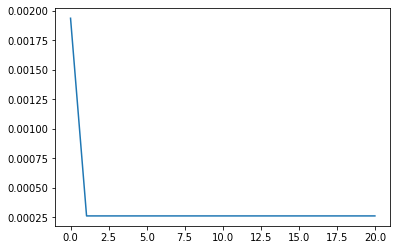

In [27]:
x = np.linspace(0,20, num=20)
y = np.array(costs).reshape((x.shape))
plt.figure
plt.plot(x,y)

## Testing

In [33]:
# Predicting the test set results:
predictions = []
for i in range(0, x_testing.shape[0]):
  x = x_testing[i].reshape((x_testing[i].size, 1))
  y = y_testing[i]
  y_pred = classifier.predict(x)
  predictions.append(y_pred)
print(np.array(predictions).reshape(len(predictions),))
print(y_testing.reshape((y_testing.shape[0],)))

[1.42158145e-10 7.25811630e-12 1.80194100e-15 1.42827914e-12
 3.59434253e-10 3.67767099e-11 2.41736157e-13 5.84839109e-17
 9.70239375e-15 4.84295301e-14 2.65319353e-16]
[0.0051 0.0079 0.0139 0.0095 0.0051 0.006  0.0103 0.0164 0.0123 0.0106
 0.0158]


# Conclusion and Recommendation
From the test results, the current model is shown to be not accurate. Changing the hyperparameters such as increasing the number of epochs and applying possible optimizations is suggested to improve the results.